# A comparison of 10K cohort thrombolysis rates across hospitals

This notebook compares the expected thrombolysis rate of a 10K cohort across 132 hospitals. The XGBoost model uses 8 features: 

* S2BrainImagingTime_min
* S2StrokeType_Infarction
* S2NihssArrival
* S1OnsetTimeType_Precise
* S2RankinBeforeStroke
* StrokeTeam
* AFAnticoagulent_Yes
* S1OnsetToArrival_min 

## Aims:

* Train XGBoost model on all data except for a 10K set of patients
* Predict use of thrombolysis in 10K cohort at each of 132 hospitals (by changing hospital one-hot coding).

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

## Create output folders if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Load data

In [3]:
data_loc = '../data/kfold_5fold/'

train_data, test_data = [], []

# Load features (and add S2Thrombolysis)
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
key_features.append('S2Thrombolysis')

for i in range(5):
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train_data.append(train)
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test_data.append(test)

## Combined XGBoost Model

### Train model

In [4]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy}')

Accuracy: 0.8442392161279423


### Pass 10k cohort through all hospital models and get thrombolysis rate

In [5]:
hospitals = list(set(train['StrokeTeam']))
hospitals.sort()
thrombolysis_rate = []
single_predictions = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['S2Thrombolysis', 'StrokeTeam'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

Sort by hospital 10K thrombolysis rate.

In [6]:
thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', inplace=True, ascending=False)

# Save
thrombolysis_by_hosp.to_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_label='stroke_team')

### Plot thrombolysis rate of 10K cohort at each hospital

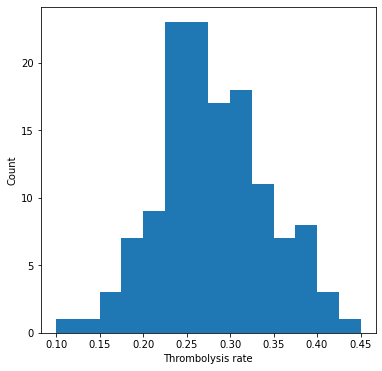

In [7]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [8]:
mean = np.mean(thrombolysis_by_hosp['Thrombolysis rate'])
stdev = np.std(thrombolysis_by_hosp['Thrombolysis rate'])
minimum = np.min(thrombolysis_by_hosp['Thrombolysis rate'])
maximum = np.max(thrombolysis_by_hosp['Thrombolysis rate'])

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')
print (f'Min: {minimum:0.3f}')
print (f'Max{maximum:0.3f}')

Mean: 0.280
StDev: 0.062
Min: 0.101
Max0.447


## Observations

* The 10K cohort model had an accuracy of 85.2%, in line with accuracy from k-fold testing.
* The predicted thrombolysis use in the 10K cohort of patients ranged from 10% to 45%.